In [155]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
from sklearn.preprocessing import StandardScaler

url_api = "https://api.coursera.org/api/courses.v1"
params = {'limit': 50}
response_api = requests.get(url_api, params=params)

if response_api.status_code == 200:
    data_api = response_api.json()
    courses_api = data_api['elements']
    df_api = pd.DataFrame(courses_api)
    df_api = df_api[['id', 'name', 'courseType']]
    df_api['source'] = 'API'
    print(df_api.head())
else:
    print("Ошибка при запросе данных с API")

                       id                                               name  \
0  l31la3mKEe-zFg7heHyXOQ  Getting started with the Vertex AI Gemini 1.5 ...   
1  OK4S2mhbEfCCGA7lN4veKQ  SPSS: Apply & Interpret Logistic Regression Mo...   
2  mukrVoSKEe-L8RKezlgehQ  Securing Compute Engine Applications and Resou...   
3  DMkcgX7LEeyRTg6FtAvfBw  Intégrer des applications dans votre Dashboard...   
4  ecoAPNowEe22LAo38arT7w         Overcoming  Challenges in Self and Society   

    courseType source  
0  v2.ondemand    API  
1  v2.ondemand    API  
2  v2.ondemand    API  
3  v2.ondemand    API  
4  v2.ondemand    API  


In [156]:
url_web = "https://webscraper.io/test-sites/e-commerce/static/computers/laptops"
headers = {"User-Agent": "Mozilla/5.0"}
response_web = requests.get(url_web, headers=headers)

In [157]:
if response_web.status_code == 200:
    soup = BeautifulSoup(response_web.text, "html.parser")
    print("Page title:", soup.title.text.strip())

    rows = []
    cards = soup.select(".thumbnail")
    for card in cards:
        title = card.select_one("a.title").get_text(strip=True)
        price = float(card.select_one("h4.price").get_text(strip=True).replace("$", ""))
        review_text = card.select_one("p.review-count").get_text(strip=True)
        match = re.search(r"\d+", review_text)
        rating = int(match.group()) if match else 0  # Если рейтинга нет, ставим 0
        rows.append({"title": title, "price": price, "rating": rating})

    df_web = pd.DataFrame(rows)
    df_web['source'] = 'Web Scraping'
    print(df_web.head())
else:
    print("Ошибка при запросе данных с веб-страницы")

df_combined = pd.merge(df_api, df_web, left_on='name', right_on='title', how='outer')

print(df_combined.head())

Page title: Static | Web Scraper Test Sites
            title    price  rating        source
0  Packard 255 G2   416.99       2  Web Scraping
1   Aspire E1-510   306.99       2  Web Scraping
2  ThinkPad T540p  1178.99       2  Web Scraping
3         ProBook   739.99       8  Web Scraping
4   ThinkPad X240  1311.99      12  Web Scraping
                       id                                               name  \
0  qB62RZp5Ee-rwhIp96UKPw       Advancing Mask Technology for Semiconductors   
1                     NaN                                                NaN   
2                     NaN                                                NaN   
3  1dph_mZFEe-EPwr_9XyAcQ                 Brand Identity and Vector Graphics   
4  DX6sNLStEeyQSBIjGmLcFQ  Building No-Code Apps with AppSheet: Implement...   

    courseType source_x           title   price  rating      source_y  
0  v2.ondemand      API             NaN     NaN     NaN           NaN  
1          NaN      NaN   Aspire E1-5

In [158]:
df_cleaned = df.drop_duplicates()

In [143]:
print(df_cleaned.isnull().sum())

df_cleaned['price'] = df_cleaned['price'].fillna(df_cleaned['price'].mean())
df_cleaned['rating'] = df_cleaned['rating'].fillna(df_cleaned['rating'].mean())

if 'category' not in df_cleaned.columns:
    df_cleaned['category'] = 'Uncategorized'

df_cleaned['category'] = df_cleaned['category'].fillna(df_cleaned['category'].mode()[0])

print(df_cleaned.head())

title     0
price     0
rating    0
dtype: int64
            title    price  rating       category
0  Packard 255 G2   416.99       2  Uncategorized
1   Aspire E1-510   306.99       2  Uncategorized
2  ThinkPad T540p  1178.99       2  Uncategorized
3         ProBook   739.99       8  Uncategorized
4   ThinkPad X240  1311.99      12  Uncategorized


In [144]:
df_cleaned['price'] = df_cleaned['price'].replace({r'\$': '', r',': ''}, regex=True).astype(float)

print(df_cleaned.head())


            title    price  rating       category
0  Packard 255 G2   416.99       2  Uncategorized
1   Aspire E1-510   306.99       2  Uncategorized
2  ThinkPad T540p  1178.99       2  Uncategorized
3         ProBook   739.99       8  Uncategorized
4   ThinkPad X240  1311.99      12  Uncategorized


In [146]:
average_price = df_cleaned['price'].mean()
average_rating = df_cleaned['rating'].mean()

correlation = df_cleaned['price'].corr(df_cleaned['rating'])

print(f"Средняя цена: {average_price}")
print(f"Средний рейтинг: {average_rating}")
print(f"Корреляция между ценой и рейтингом: {correlation}")

Средняя цена: 756.1566666666666
Средний рейтинг: 4.666666666666667
Корреляция между ценой и рейтингом: 0.6185946467289936


In [147]:
scaler = StandardScaler()

df_cleaned[['price', 'rating']] = scaler.fit_transform(df_cleaned[['price', 'rating']])

print(df_cleaned.head())

            title     price    rating       category
0  Packard 255 G2 -0.909106 -0.676123  Uncategorized
1   Aspire E1-510 -1.203952 -0.676123  Uncategorized
2  ThinkPad T540p  1.133367 -0.676123  Uncategorized
3         ProBook -0.043333  0.845154  Uncategorized
4   ThinkPad X240  1.489862  1.859339  Uncategorized


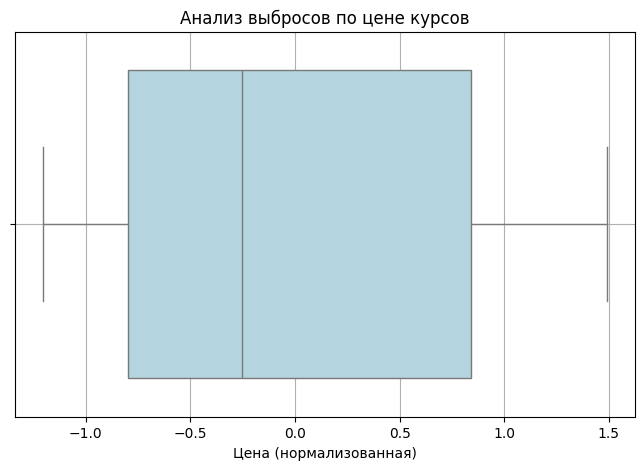

In [148]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df_cleaned['price'], color='lightblue')
plt.title('Анализ выбросов по цене курсов')
plt.xlabel('Цена (нормализованная)')
plt.grid(True)
plt.show()

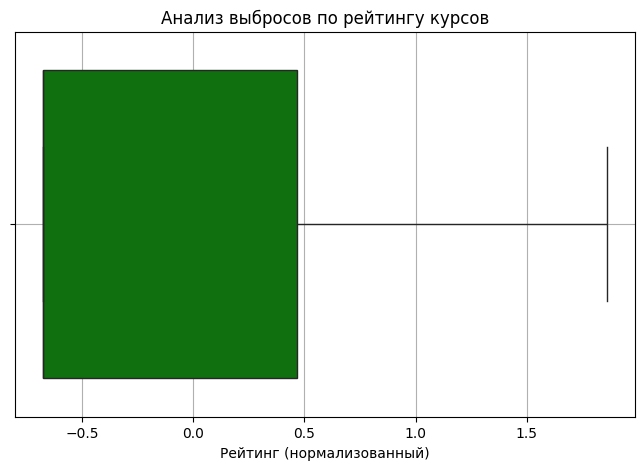

In [149]:

plt.figure(figsize=(8, 5))
sns.boxplot(x=df_cleaned['rating'], color='green')
plt.title('Анализ выбросов по рейтингу курсов')
plt.xlabel('Рейтинг (нормализованный)')
plt.grid(True)
plt.show()

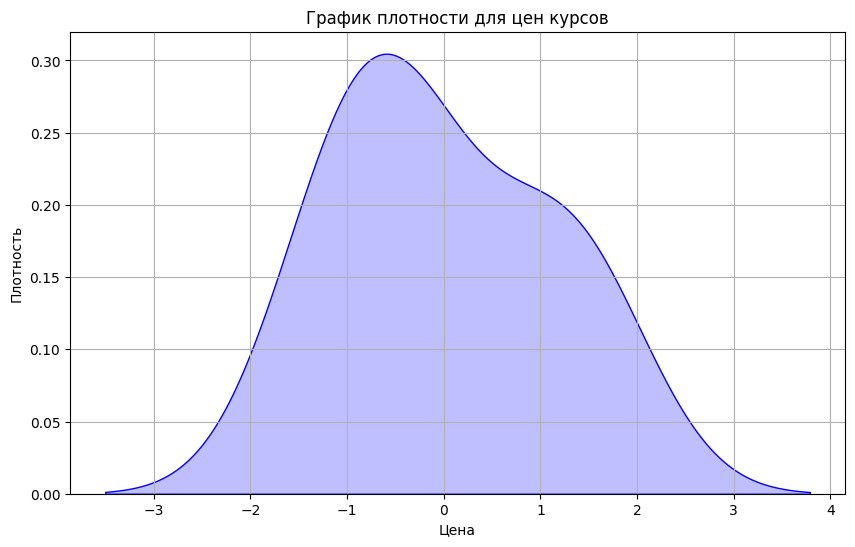

In [150]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_cleaned['price'], fill=True, color='blue')
plt.title('График плотности для цен курсов')
plt.xlabel('Цена')
plt.ylabel('Плотность')
plt.grid(True)
plt.show()


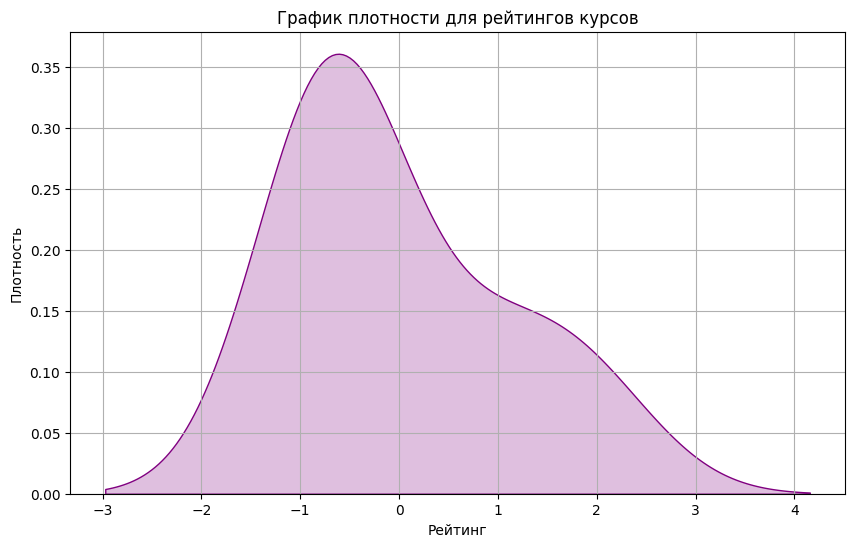

In [151]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_cleaned['rating'], fill=True, color='purple')
plt.title('График плотности для рейтингов курсов')
plt.xlabel('Рейтинг')
plt.ylabel('Плотность')
plt.grid(True)
plt.show()

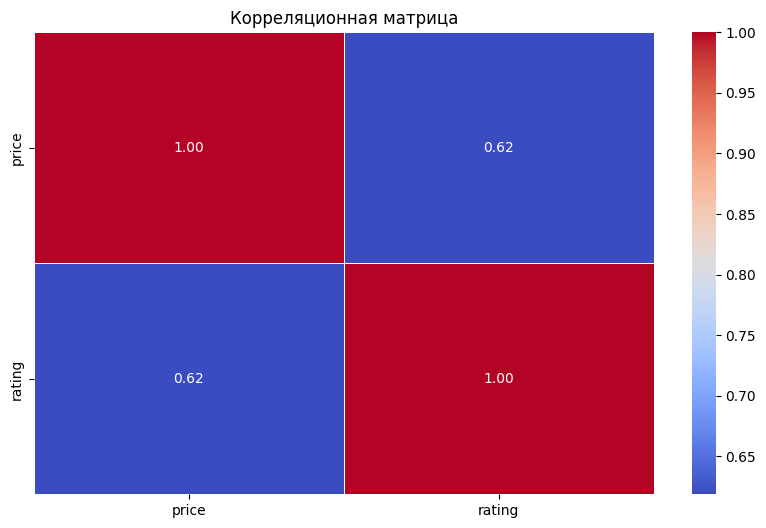

In [152]:
df_numeric = df_cleaned.select_dtypes(include=[np.number])

correlation_matrix = df_numeric.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Корреляционная матрица')
plt.show()


In [153]:
df_cleaned.to_csv("cleaned_courses.csv", index=False)
print("Данные сохранены в 'cleaned_courses.csv'")

Данные сохранены в 'cleaned_courses.csv'


In [154]:
analysis_results = pd.DataFrame({
    'average_price': [average_price],
    'average_rating': [average_rating],
    'correlation': [correlation]
})
analysis_results.to_csv("analysis_results.csv", index=False)
print("Результаты сохранены")

Результаты сохранены
